In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from cifar_model import generator,discriminator,cnn
import utils

/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


'''
build unl data pipeline 
train gan cifar10 kinglsey
generate adv pert
train takeru or simple cnn cifar
get gains !
'''

In [2]:
params = dict(
    batch_size = 50,
    seed = 1234,
    z_dim = 100,
    lr = 1e-4,
    logdir = 'cifar_gans/',
    name_model = 'model_kingsley'
)
rng = np.random.RandomState(params['seed'])  # seed labels

In [19]:
params_dnn = dict(
    batch=50,
    lr = 1e-4,
    labeled = 100,
    seed = 1234,
    epoch=501
)

## Data

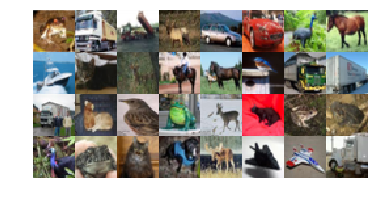

In [4]:
(trainx, trainy), (testx, testy) = tf.keras.datasets.cifar10.load_data()
def rescale(mat):
    return ((-127.5 + mat) / 127.5)
trainx = rescale(trainx)
testx = rescale(testx)
trainy = np.squeeze(trainy)
testy = np.squeeze(testy)
trainx_unl = trainx.copy()
nr_batch_unl = trainx_unl.shape[0] // params['batch_size']
utils.show_cifar(trainx_unl[:32])

train: (1000, 32, 32, 3) test: (10000, 32, 32, 3)


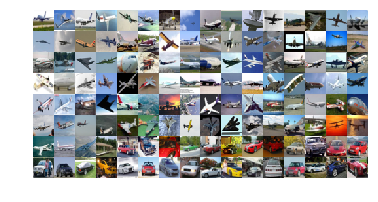

In [5]:
inds = rng.permutation(trainx.shape[0])
trainx = trainx[inds]
trainy = trainy[inds]
txs = []
tys = []
for j in range(10):
    txs.append(trainx[trainy == j][:params_dnn['labeled']])
    tys.append(trainy[trainy == j][:params_dnn['labeled']])
txs = np.concatenate(txs, axis=0)
tys = np.concatenate(tys, axis=0)
trainx = txs
trainy = tys
nr_batch_train = trainx.shape[0] // params_dnn['batch']
nr_batch_test = testx.shape[0] // params_dnn['batch']
print('train:',trainx.shape,'test:',testx.shape)
utils.show_cifar(trainx[:128])

## GAN training

In [6]:
unl = tf.placeholder(tf.float32, [params['batch_size'], 32,32,3])
is_training_pl = tf.placeholder(tf.bool, [], name='is_training_pl')
noise = tf.random_normal(shape=[params['batch_size'],params['z_dim']])

samples = generator(noise,is_training=is_training_pl,reuse=tf.AUTO_REUSE)
real_score = discriminator(unl,is_training=is_training_pl,reuse=tf.AUTO_REUSE)
fake_score = discriminator(samples,is_training=is_training_pl,reuse=tf.AUTO_REUSE)

gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator") 

loss_g = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score,labels=tf.ones_like(fake_score)))
loss_d = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_score,labels=tf.ones_like(fake_score)))+\
tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score,labels=tf.zeros_like(fake_score)))

optimizer = tf.train.AdamOptimizer(learning_rate=params['lr'], beta1=0.5)

update_ops_gen = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')
update_ops_dis = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='discriminator')

with tf.control_dependencies(update_ops_gen): # attached op for moving average batch norm
    traing = optimizer.minimize(loss_g,var_list=gen_vars)
with tf.control_dependencies(update_ops_dis):
    traind = optimizer.minimize(loss_d,var_list=disc_vars)

In [7]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [8]:
saver = tf.train.Saver()

In [9]:
path = './gan_cifar_saved/'
if tf.train.latest_checkpoint(path) is not None:
    path = saver.restore(sess, tf.train.latest_checkpoint(path))
else:
    print('no model found')

INFO:tensorflow:Restoring parameters from ./gan_cifar_saved/kingsley


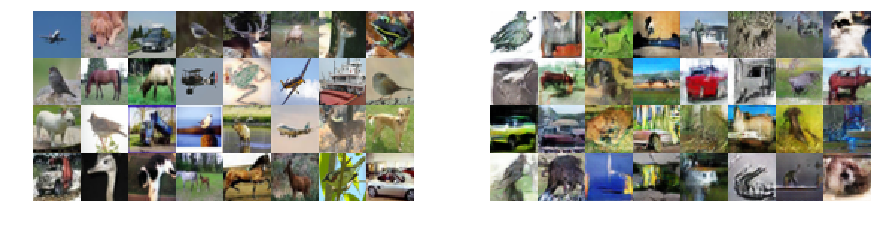

KeyboardInterrupt: 

In [10]:
viz_every = 500
for epoch in tqdm(range(10001)):
    trainx_unl = trainx_unl[rng.permutation(trainx_unl.shape[0])]  # shuffling unl dataset   
    
    for step in range(nr_batch_unl):
        ran_from = step * params['batch_size']
        ran_to = (step + 1) * params['batch_size']
        sess.run(traind,{is_training_pl:True,unl:trainx_unl[ran_from:ran_to]})
        sess.run(traing,{is_training_pl:True,unl:trainx_unl[ran_from:ran_to]})

        if (step) % viz_every == 0:
            xx, yy = sess.run([unl,samples],{is_training_pl:False,unl:trainx_unl[ran_from:ran_to]})
            plt.figure(figsize=(15,5))
            plt.subplot(121)
            utils.show_cifar(xx[:32])
            plt.subplot(122)
            utils.show_cifar(yy[:32])
            plt.show()


In [19]:
saver.save(sess, './gan_cifar_saved/kingsley')

'./gan_cifar_saved/kingsley'

## Vizualization manifold examples

In [11]:
# ############ MANIFOLD ##########
z1 = tf.random_normal(shape=[params['batch_size'],params['z_dim']])
pert_n = tf.nn.l2_normalize(tf.random_normal(shape=[params['batch_size'],params['z_dim']]),dim=[1])
z1_pert = z1 + 1. * pert_n
pz = tf.random_normal([params['batch_size'],32,32,1],stddev=0.2) 

samp_z1 = generator(z1,is_training=is_training_pl,reuse=tf.AUTO_REUSE)
samp_z2 = generator(z1_pert,is_training=is_training_pl,reuse=tf.AUTO_REUSE)
samp_adv = samp_z1 + 20.* tf.nn.l2_normalize(samp_z2-samp_z1,dim=[1,2,3])


In [12]:
xx,yy = sess.run([samp_z1,samp_adv],{is_training_pl:False})
xx = (xx+1.)/2.
yy = (yy+1.)/2.
yy[yy>1.]=1
yy[yy<0]=0

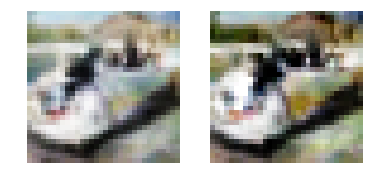

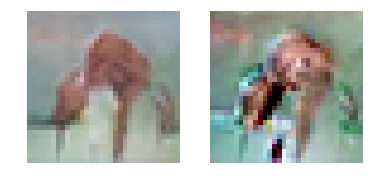

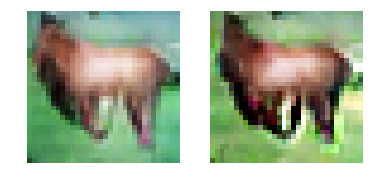

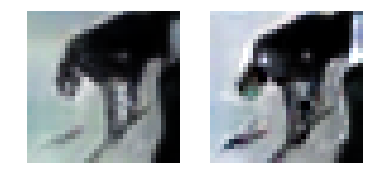

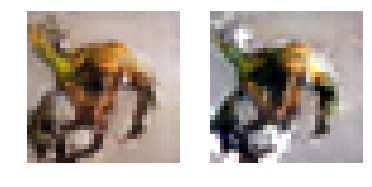

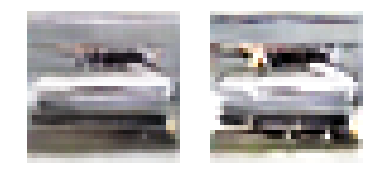

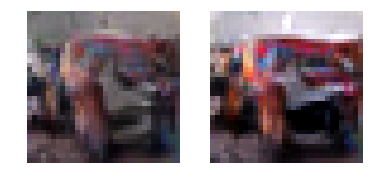

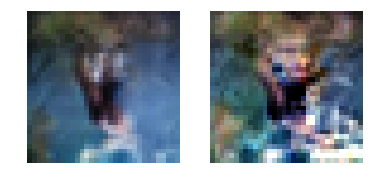

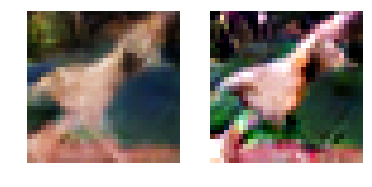

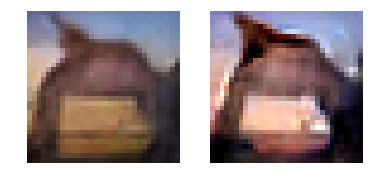

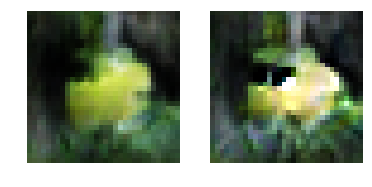

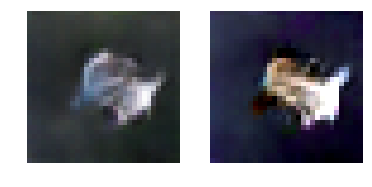

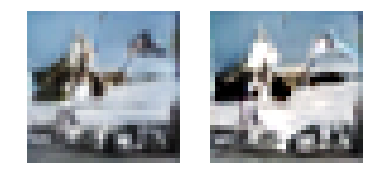

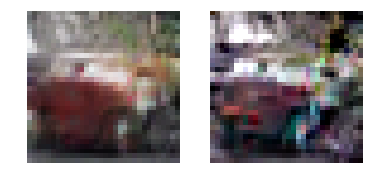

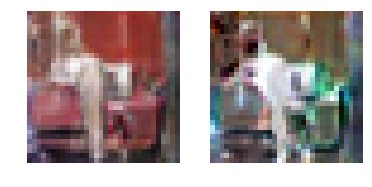

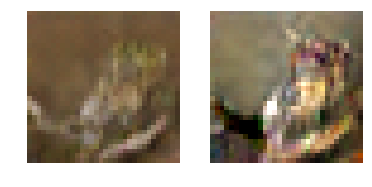

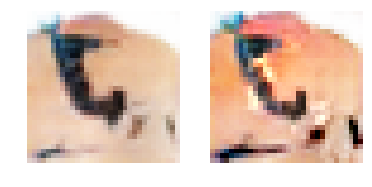

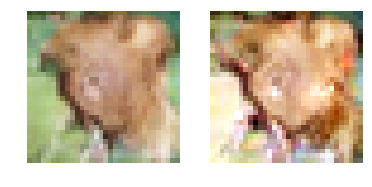

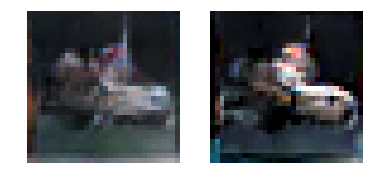

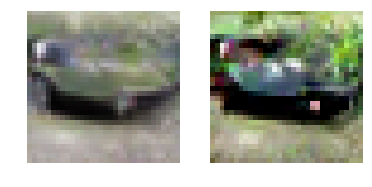

In [13]:
for idx in range(20):
    plt.subplot(1,2,1)
    plt.imshow(np.squeeze(xx[idx]))
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(np.squeeze(yy[idx]))
    plt.axis('off')
    plt.show()

## Training CNN

In [14]:
inp = tf.placeholder(tf.float32, [params_dnn['batch'], 32,32,3])
lbl = tf.placeholder(tf.int64, [params_dnn['batch']])
training_cnn  = tf.placeholder(tf.bool,[])
logits = cnn(inp,training_cnn)
xloss = tf.losses.sparse_softmax_cross_entropy(logits=logits,labels=lbl)

In [15]:
logits_z1= cnn(samp_z1,training_cnn)
logits_z2 = cnn(samp_z2+pz,training_cnn)
logits_adv = cnn(samp_adv,training_cnn) # ADD PZ 

manifold = tf.reduce_sum(tf.sqrt(tf.square(logits_z1-logits_adv)+1e-8),axis=1)
manifold_loss = tf.reduce_mean(manifold)

In [16]:
loss = xloss #+ 0.01 * manifold_loss

In [17]:
with tf.variable_scope("adam",reuse=tf.AUTO_REUSE):
    global_step = tf.Variable(0, name='global_step',trainable=False)
    optimizer = tf.train.AdamOptimizer(learning_rate=params_dnn['lr'])
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS,scope='classifier')  # control dependencies for batch norm ops
    with tf.control_dependencies(update_ops):
        train_op = optimizer.minimize(loss,var_list=tf.trainable_variables(scope='classifier'),global_step=global_step)
        
correct_prediction = tf.equal(tf.argmax(logits,1),lbl)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [22]:
#init
var = tf.global_variables(scope='classifier')+tf.global_variables(scope='adam')
init_op = tf.variables_initializer(var_list=var)

In [23]:
sess.run(init_op)
train_array = [];test_array=[]; loss_array=[]; manifold_array=[]


Epoch: 0,Global steps: 20, xloss: 2.29165, maniloss: 2.08758, training acc: 13.60%, test acc: 10.00%
Epoch: 1,Global steps: 40, xloss: 2.08098, maniloss: 3.01142, training acc: 24.50%, test acc: 10.25%
Epoch: 2,Global steps: 60, xloss: 1.95132, maniloss: 3.61971, training acc: 28.60%, test acc: 12.07%
Epoch: 3,Global steps: 80, xloss: 1.86533, maniloss: 3.98079, training acc: 32.10%, test acc: 13.28%
Epoch: 4,Global steps: 100, xloss: 1.79055, maniloss: 4.30249, training acc: 34.40%, test acc: 14.16%
Epoch: 5,Global steps: 120, xloss: 1.73423, maniloss: 4.37824, training acc: 37.00%, test acc: 15.46%
Epoch: 6,Global steps: 140, xloss: 1.67790, maniloss: 4.61657, training acc: 40.20%, test acc: 18.70%
Epoch: 7,Global steps: 160, xloss: 1.61410, maniloss: 4.98595, training acc: 43.00%, test acc: 21.88%
Epoch: 8,Global steps: 180, xloss: 1.58404, maniloss: 5.16681, training acc: 42.70%, test acc: 22.99%
Epoch: 9,Global steps: 200, xloss: 1.53996, maniloss: 5.13507, training acc: 45.20%, 

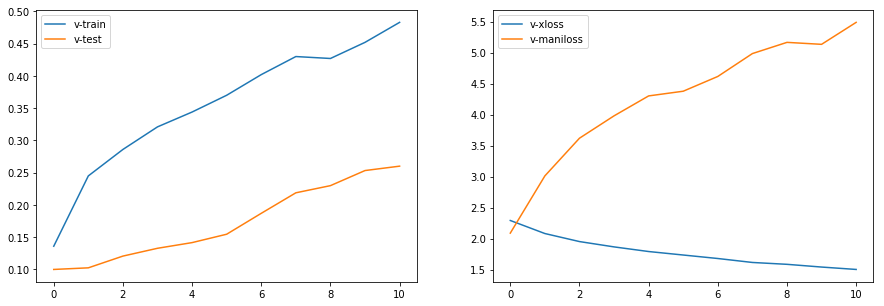

Epoch: 11,Global steps: 240, xloss: 1.49130, maniloss: 5.58635, training acc: 46.60%, test acc: 22.26%
Epoch: 12,Global steps: 260, xloss: 1.44967, maniloss: 5.70673, training acc: 50.50%, test acc: 26.55%
Epoch: 13,Global steps: 280, xloss: 1.42551, maniloss: 6.08833, training acc: 49.40%, test acc: 25.69%
Epoch: 14,Global steps: 300, xloss: 1.38339, maniloss: 6.16070, training acc: 51.00%, test acc: 27.58%
Epoch: 15,Global steps: 320, xloss: 1.37115, maniloss: 6.03801, training acc: 53.10%, test acc: 31.41%
Epoch: 16,Global steps: 340, xloss: 1.34268, maniloss: 6.30089, training acc: 53.30%, test acc: 26.02%
Epoch: 17,Global steps: 360, xloss: 1.29213, maniloss: 6.40607, training acc: 53.70%, test acc: 27.65%
Epoch: 18,Global steps: 380, xloss: 1.27551, maniloss: 6.35411, training acc: 56.80%, test acc: 25.22%
Epoch: 19,Global steps: 400, xloss: 1.24554, maniloss: 6.50407, training acc: 56.50%, test acc: 28.55%
Epoch: 20,Global steps: 420, xloss: 1.23947, maniloss: 6.57321, training 

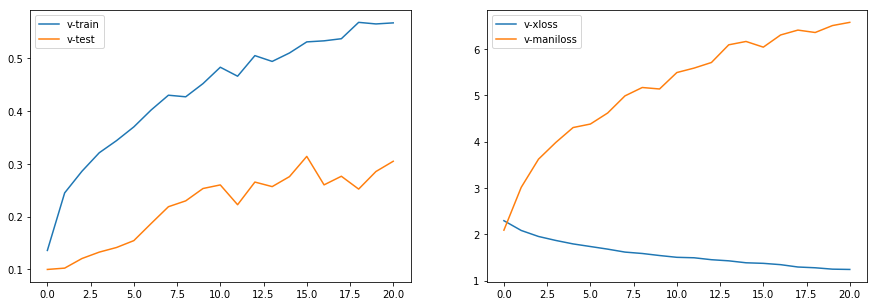

Epoch: 21,Global steps: 440, xloss: 1.19770, maniloss: 6.90005, training acc: 59.00%, test acc: 30.84%
Epoch: 22,Global steps: 460, xloss: 1.18735, maniloss: 7.13782, training acc: 58.80%, test acc: 26.49%
Epoch: 23,Global steps: 480, xloss: 1.17327, maniloss: 7.04339, training acc: 59.30%, test acc: 30.24%
Epoch: 24,Global steps: 500, xloss: 1.12997, maniloss: 6.92912, training acc: 60.30%, test acc: 29.32%
Epoch: 25,Global steps: 520, xloss: 1.13168, maniloss: 7.29051, training acc: 60.70%, test acc: 30.43%
Epoch: 26,Global steps: 540, xloss: 1.12087, maniloss: 7.32385, training acc: 60.00%, test acc: 34.02%
Epoch: 27,Global steps: 560, xloss: 1.07746, maniloss: 7.44240, training acc: 63.30%, test acc: 33.90%
Epoch: 28,Global steps: 580, xloss: 1.04434, maniloss: 7.25449, training acc: 63.40%, test acc: 30.01%
Epoch: 29,Global steps: 600, xloss: 1.01636, maniloss: 7.53245, training acc: 66.10%, test acc: 30.36%
Epoch: 30,Global steps: 620, xloss: 1.02311, maniloss: 7.61127, training 

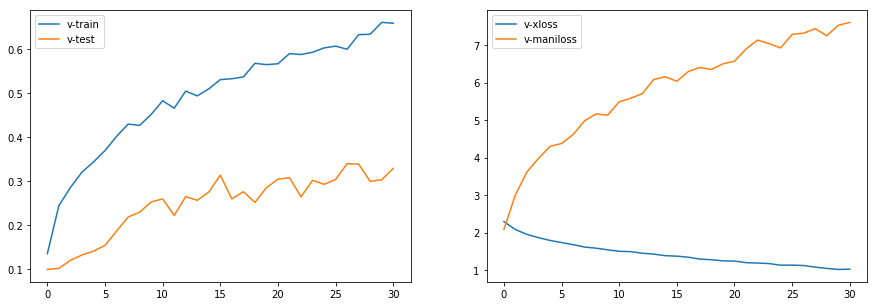

Epoch: 31,Global steps: 640, xloss: 1.00411, maniloss: 7.79016, training acc: 66.90%, test acc: 30.83%
Epoch: 32,Global steps: 660, xloss: 0.97679, maniloss: 7.84881, training acc: 65.30%, test acc: 30.25%
Epoch: 33,Global steps: 680, xloss: 0.98392, maniloss: 8.00062, training acc: 66.80%, test acc: 29.06%
Epoch: 34,Global steps: 700, xloss: 0.95834, maniloss: 7.98525, training acc: 68.10%, test acc: 30.61%
Epoch: 35,Global steps: 720, xloss: 0.92091, maniloss: 7.72682, training acc: 70.20%, test acc: 29.46%
Epoch: 36,Global steps: 740, xloss: 0.93331, maniloss: 8.13949, training acc: 69.10%, test acc: 30.99%
Epoch: 37,Global steps: 760, xloss: 0.90561, maniloss: 8.06442, training acc: 69.50%, test acc: 28.19%
Epoch: 38,Global steps: 780, xloss: 0.85607, maniloss: 8.07160, training acc: 72.50%, test acc: 32.15%
Epoch: 39,Global steps: 800, xloss: 0.88014, maniloss: 8.29348, training acc: 71.40%, test acc: 33.17%
Epoch: 40,Global steps: 820, xloss: 0.84686, maniloss: 8.07915, training 

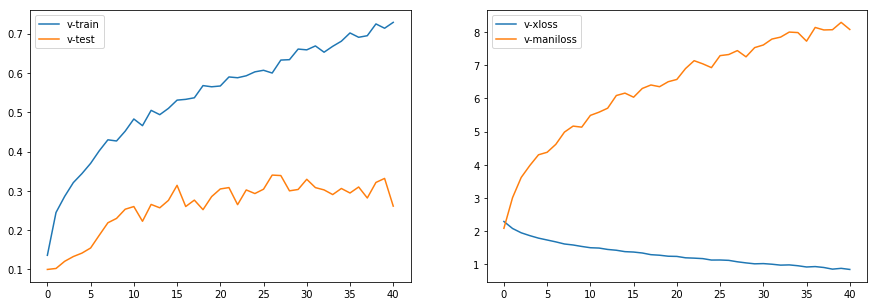

Epoch: 41,Global steps: 840, xloss: 0.83641, maniloss: 8.55901, training acc: 72.00%, test acc: 30.10%
Epoch: 42,Global steps: 860, xloss: 0.83452, maniloss: 8.53926, training acc: 72.40%, test acc: 30.73%
Epoch: 43,Global steps: 880, xloss: 0.79290, maniloss: 8.68799, training acc: 75.10%, test acc: 33.51%
Epoch: 44,Global steps: 900, xloss: 0.82215, maniloss: 8.88088, training acc: 73.50%, test acc: 31.85%


In [ ]:
for epoch in tqdm(range(params_dnn['epoch'])):
    inds = rng.permutation(trainx.shape[0])
    trainx = trainx[inds]
    trainy = trainy[inds]
    train_acc=test_acc=train_loss=train_manifold=0
    
    for step in range(nr_batch_train):
        ran_from = step * params_dnn['batch']
        ran_to = (step+1) * params_dnn['batch']
        xl, _ , acc,ml =  sess.run([xloss,train_op, accuracy,manifold_loss], {inp: trainx[ran_from:ran_to],
                                                                             lbl: trainy[ran_from:ran_to],
                                                                             is_training_pl:False,
                                                                             training_cnn:True})
        train_acc += acc; train_loss += xl; train_manifold += ml
    train_acc /= nr_batch_train; train_loss /= nr_batch_train; train_manifold /= nr_batch_train
    train_array.append(train_acc);loss_array.append(train_loss);manifold_array.append(train_manifold)
    for step in range(nr_batch_test):
        ran_from = step * params_dnn['batch']
        ran_to = (step+1) * params_dnn['batch']
        test_acc += sess.run(accuracy, {inp: testx[ran_from:ran_to],
                                         lbl: testy[ran_from:ran_to],
                                         training_cnn:False})
    test_acc /= nr_batch_test; test_array.append(test_acc)
    print("Epoch: {},Global steps: {}, xloss: {:.5f}, maniloss: {:.5f}, training acc: {:.2f}%, test acc: {:.2f}%".format(
            epoch, sess.run(global_step),train_loss, train_manifold,train_acc * 100,test_acc*100))
    
    if (epoch != 0) & (epoch % 10 == 0):
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.plot(train_array)
        plt.plot(test_array)
        plt.legend(['v-train','v-test','train','test'])
        plt.subplot(122)
        plt.plot(loss_array)
        plt.plot(manifold_array)
        plt.legend(['v-xloss','v-maniloss','xloss','maniloss'])
        plt.show()

In [122]:
# v_train = train_array
# v_test = test_array
# v_loss = loss_array
# v_mani = manifold_array

# t0_train = train_array #sans pz et gamma = 0.001
# t0_test = test_array
# t0_loss = loss_array
# t0_mani = manifold_array

# t1_train = train_array #avec pz et gamma = 0.01
# t1_test = test_array
# t1_loss = loss_array
# t1_mani = manifold_array

# t1_train = train_array #avec pz et gamma = 0.01
# t1_test = test_array
# t1_loss = loss_array
# t1_mani = manifold_array